# MNIST Handwritten Digit Recognizer
---
- The MNIST dataset is a well-known and widely used dataset in the machine learning community, particularly for tasks involving image classification. It consists of 70,000 grayscale images of handwritten digits, which are 28 pixels by 28 pixels in size and represent a single digit from 0 through 9. The images are divided into a training set of 60,000 images and a test set of 10,000 images. The dataset was created by NIST and has been widely used in research and academic settings for testing and evaluating machine learning models. 

- The MNIST dataset is well-suited for testing machine learning models for image classification tasks, particularly those involving handwritten digits. By training a machine learning model on the MNIST dataset, we can build a system that is able to recognize handwritten digits from images. This can be useful in a variety of applications, such as automating the process of transcribing handwritten documents or building a system to recognize digits in financial documents. Additionally, the small size of the images in the MNIST dataset makes it easy to train and evaluate machine learning models, making it a valuable resource for researchers and practitioners working on image classification task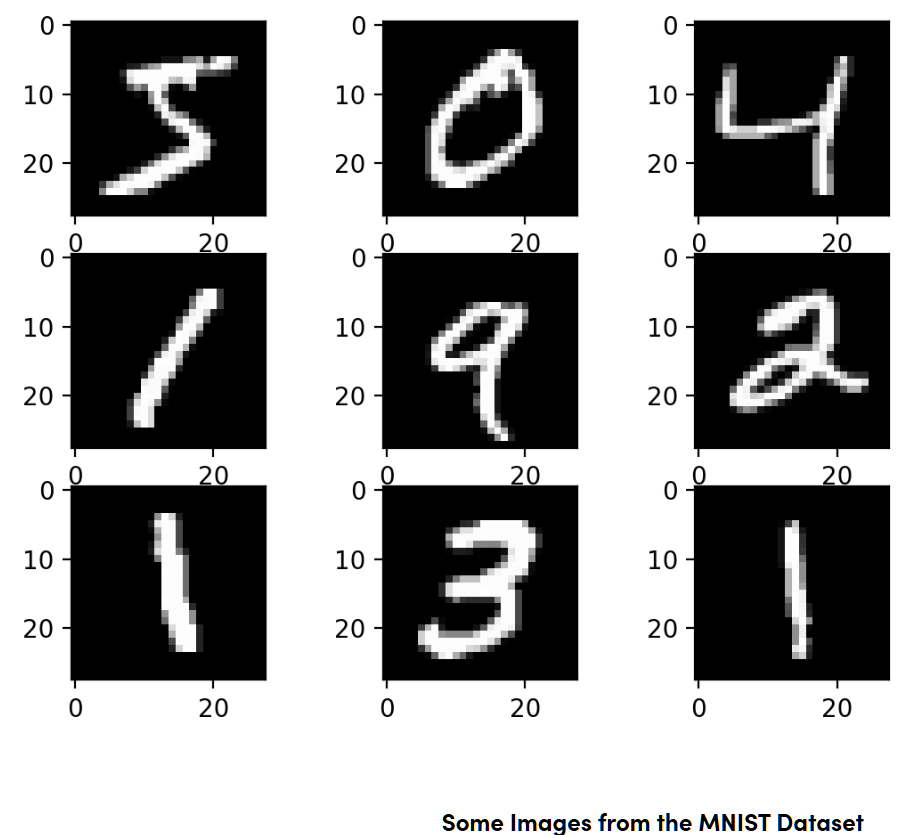a.png)

`This project will be divided into 3 main parts:`

- Working with images in Python.
- Principal Component Analysis
- Model Prediction(KNN) and Evaluation

`DatasetLink:` https://en.wikipedia.org/wiki/MNIST_database

By Yashraj Mishra

# Importing Required Libraries 

In [1]:
# The folowing library is consist of 2 parts of Model Building: PCA (Prinicipal Component Analysis) and KNN (K-Nearest Neighbour) 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Shape of training data 
print(f'Number of rows in Training :', train_df.shape[0] ,f' and Number of Columns in Training: ', train_df.shape[1])
# Shape of testing data 
print(f'Number of rows in Testing:', test_df.shape[0] ,f' and Number of Columns in Testing: ', test_df.shape[1])

Number of rows in Training : 42000  and Number of Columns in Training:  785
Number of rows in Testing: 28000  and Number of Columns in Testing:  784


In [4]:
# Checking for the null values and unique values
def find_dirty_values(data):
    dtypes = pd.DataFrame(data.dtypes,columns=["Data Type"])
    dtypes["Unique Values"]=data.nunique().sort_values(ascending=True)
    dtypes["Null Values"]=data.isnull().sum()
    dtypes["% null Values"]=data.isnull().sum()/len(data)
    return dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

In [5]:
print("Checking Null Values in Training Data") 
train_null_values = find_dirty_values(train_df)
train_null_values

Checking Null Values in Training Data


,Data Type,Unique Values,Null Values,% null Values
label,int64,10,0,0.000000
pixel515,int64,256,0,0.000000
pixel517,int64,256,0,0.000000
pixel518,int64,256,0,0.000000
pixel519,int64,256,0,0.000000
pixel520,int64,256,0,0.000000
pixel521,int64,256,0,0.000000
pixel522,int64,256,0,0.000000
pixel523,int64,256,0,0.000000
pixel524,int64,256,0,0.000000


In [6]:
print("Checking Null Values in Testing Data") 
test_null_values = find_dirty_values(test_df)
test_null_values

Checking Null Values in Testing Data


,Data Type,Unique Values,Null Values,% null Values
pixel0,int64,1,0,0.000000
pixel515,int64,256,0,0.000000
pixel517,int64,256,0,0.000000
pixel518,int64,256,0,0.000000
pixel519,int64,256,0,0.000000
pixel520,int64,256,0,0.000000
pixel521,int64,256,0,0.000000
pixel522,int64,256,0,0.000000
pixel523,int64,256,0,0.000000
pixel524,int64,256,0,0.000000


In [7]:
train_df.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [8]:
# We can see that the first colum is the label, and the rest of the columns are the 784 pixels that represent 28x28 gray-scale images.

X_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values

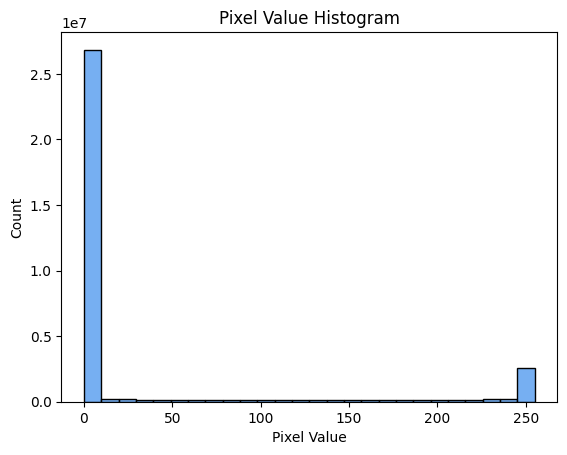

In [9]:
# Distribution of Pixel Values

ax = sns.histplot(x=X_train.flatten(), color='#4895EE')
_ = ax.set(title='Pixel Value Histogram', xlabel='Pixel Value')

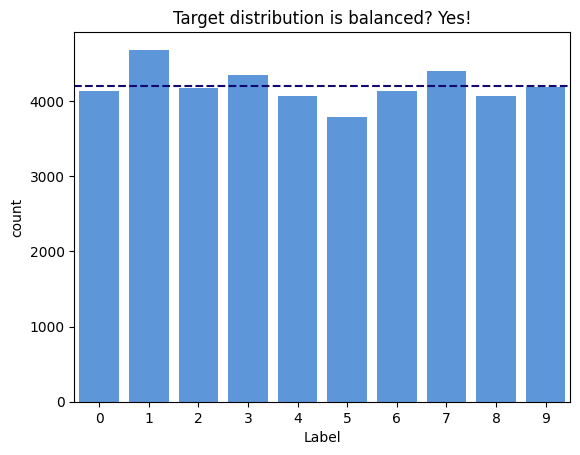

In [10]:
# It means that the ten categories in the target have roughly the same representation in the data.

ax = sns.countplot(x=y_train, color='#4895EE')
ax.set(
    title='Target distribution is balanced? Yes!',
    xlabel='Label'
)
# The expected number of samples for a balanced  class distribution is 42000/10 = 4200
_ = ax.axhline(y=4200, color='#12086F', linestyle='--')

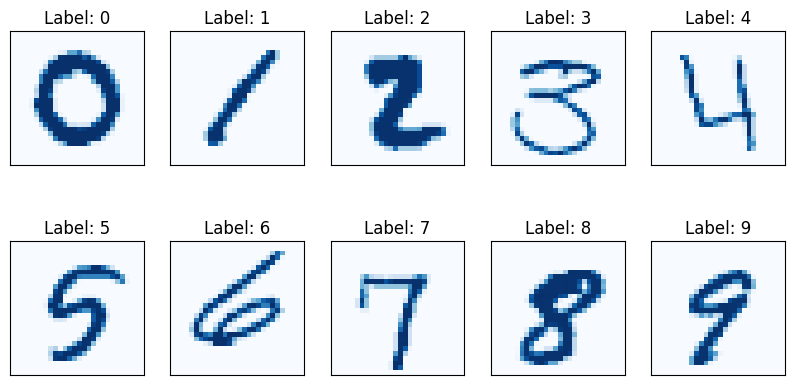

In [11]:
# Lets visualize the images 

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i in range(10):
    idx = np.where(y_train==i)[0][0]
    img = axs[int(i >= 5), i%5].imshow(
        X=X_train[idx].reshape(28, 28),
        cmap='Blues'
    )
    img.axes.get_yaxis().set_visible(False)
    img.axes.get_xaxis().set_visible(False)
    img.axes.set_title(f'Label: {i}')

# Principal Component Analysis
-------------

- Principal Comopnent Analysis (PCA) is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data.

- The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. The i-th principal component can be taken as a direction orthogonal to the first i-1 principal components that maximizes the variance of the projected data.

- sklearn.decomposition.PCA: Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

- Here, we will use the top 10 principal components, which explain almost 50% of the variance in the data. This means that we can express 50% of the variance of the data with a space of features >98% smaller than the original one (10 features vs. 784 features)tures)

In [12]:
# Normalize values 
print("Before applying MinMax Scaler:")
print(" * Minimum value:", X_train.min())
print(" * Maximum value:", X_train.max())

minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)

print("\nAfter applying MinMax Scaler:")
print(" * Minimum value:", X_train_scaled.min())
print(" * Maximum value:", X_train_scaled.max())

Before applying MinMax Scaler:
 * Minimum value: 0
 * Maximum value: 255

After applying MinMax Scaler:
 * Minimum value: 0.0
 * Maximum value: 1.0


In [13]:
# embeding the MinMaxScaler and the PCA modules into a Sklearn Pipeline.

pca = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10))
])

X_train_pca = pca.fit_transform(X=X_train)

print('X_train_pca shape:', X_train_pca.shape)

X_train_pca shape: (42000, 10)


In [14]:
# Explained variance ratio

pca_object = pca.named_steps['pca']
var_ratio = pd.Series(
    data=pca_object.explained_variance_ratio_,
    index=range(1, 11)
)

cumsum_var_ratio = var_ratio.cumsum()

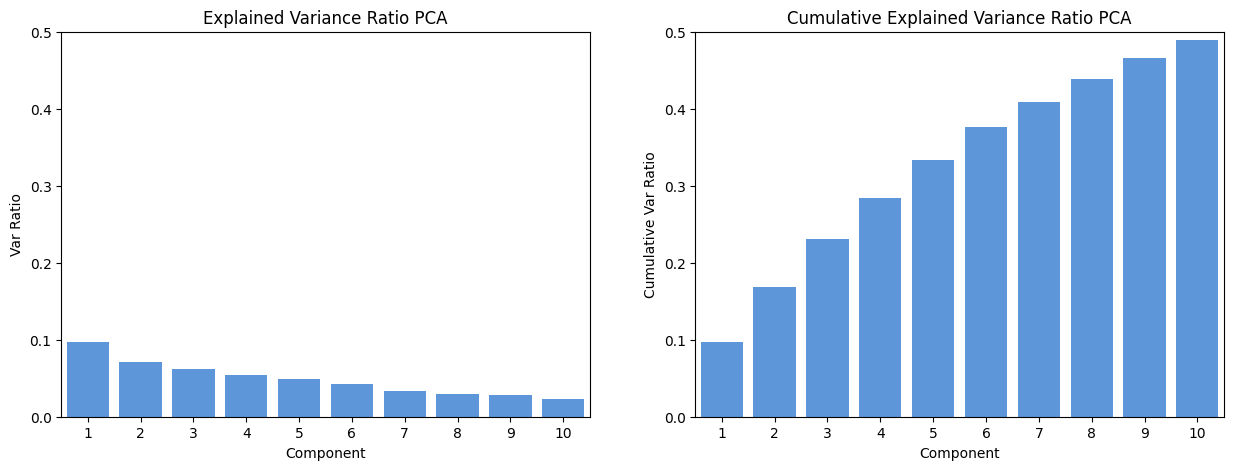

In [15]:
# Plot the explained variance ratio for each component (left)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.barplot(
    x=var_ratio.index, 
    y=var_ratio.values, 
    color='#4895EE', 
    ax=ax1
)
ax1.set(
    title='Explained Variance Ratio PCA',
    xlabel='Component',
    ylabel='Var Ratio',
)
ax1.set_ylim(0, 0.5)

sns.barplot(
    x=cumsum_var_ratio.index, 
    y=cumsum_var_ratio.values, 
    color='#4895EE', 
    ax=ax2
)
ax2.set(
    title='Cumulative Explained Variance Ratio PCA',
    xlabel='Component',
    ylabel='Cumulative Var Ratio',
)
_ = ax2.set_ylim(0, 0.5)

In [16]:
df_train_pca = pd.DataFrame(
    data=X_train_pca[:,:3], 
    columns=['x', 'y', 'z']
)

df_train_pca['target'] = y_train

print(df_train_pca.shape)
df_train_pca.head()

(42000, 4)


,x,y,z,target
0,-2.594493,-2.742397,0.718746,1
1,6.672360,-1.413927,-1.967859,0
2,-3.478017,-1.152023,0.263354,1
3,-0.650022,1.177187,-0.251552,4
4,7.543960,-1.761384,-2.151420,0


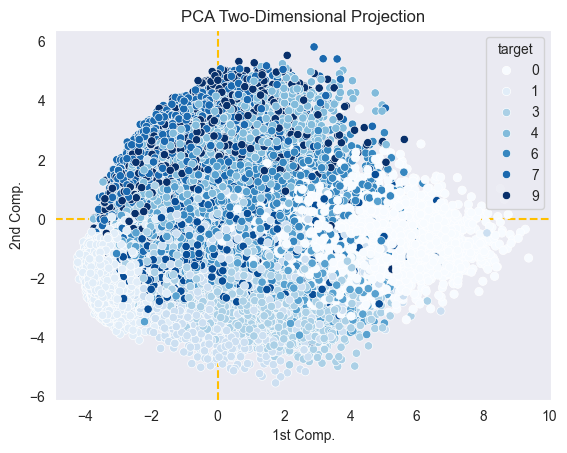

In [17]:
# Two-dimensional visualization of the data belongs to top two PCA

sns.set_style("dark")
ax = sns.scatterplot(
    data=df_train_pca,
    x='x', 
    y='y', 
    hue='target', 
    palette='Blues',
)
ax.set(
    title='PCA Two-Dimensional Projection',
    xlabel='1st Comp.',
    ylabel='2nd Comp.'
)
ax.axhline(y=0, linestyle='--', color='#FFBF00', zorder=-1)
ax.axvline(x=0, linestyle='--', color='#FFBF00', zorder=-1)

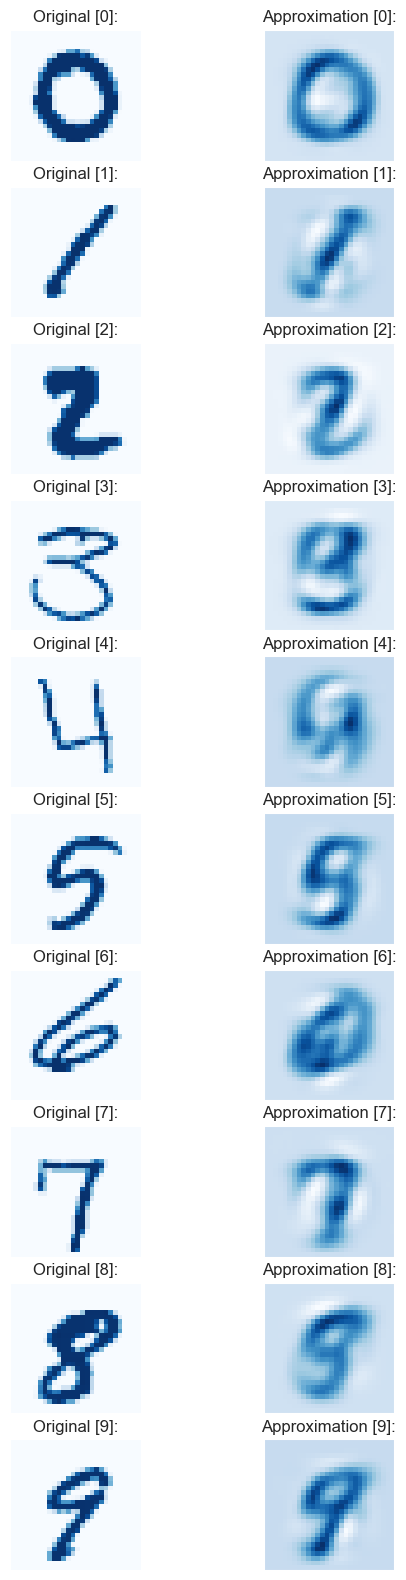

In [18]:
# compontents.
# We can see that with just 10 components we convey a large
# part of the information of each image.

pca_object = pca.named_steps['pca']

fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(6,20))

for i in range(10):
    idx = np.where(y_train==i)[0][0]
    original_img = axs[i, 0].imshow(
        X=X_train[idx].reshape(28, 28),
        cmap='Blues'
    )
    original_img.axes.get_yaxis().set_visible(False)
    original_img.axes.get_xaxis().set_visible(False)
    original_img.axes.set_title(f'Original [{i}]:')
    
    approx_img_ = pca_object.inverse_transform(X=X_train_pca[idx])
    approx_img = axs[i, 1].imshow(
        X=approx_img_.reshape(28, 28),
        cmap='Blues'
    )
    approx_img.axes.get_yaxis().set_visible(False)
    approx_img.axes.get_xaxis().set_visible(False)
    approx_img.axes.set_title(f'Approximation [{i}]:')

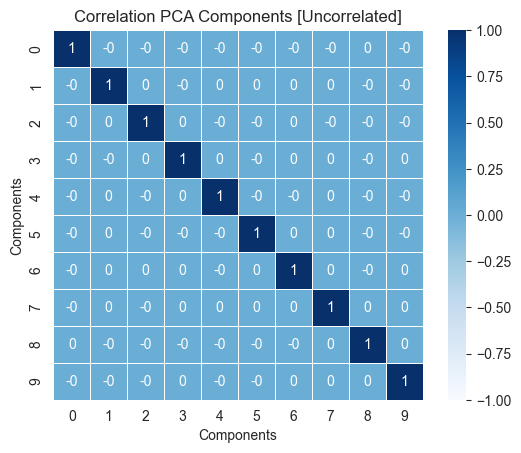

In [19]:
# Seeing if PCA Components are unco-related
corr = np.corrcoef(x=X_train_pca, rowvar=False)
corr = np.around(corr, decimals=2)

ax = sns.heatmap(
    data=corr, 
    vmax=1, 
    vmin=-1,
    square=True,
    linewidths=.5,
    annot=True,
    cmap='Blues',
)

_ = ax.set(
    title='Correlation PCA Components [Uncorrelated]',
    xlabel='Components',
    ylabel='Components'
)

# K Nearest Neighbour
-------------
- The K-Nearest Neighbors algorithm is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. Prediction: A class label is assigned on the basis of a majority vote. the label that is most frequently represented around a given data point.

- In this project, the input of the KNN Classifier will be the top 10 principal components from the PCA.

In [20]:
knn_clf = Pipeline(steps=[('scaler', MinMaxScaler()),('pca', PCA(n_components=10)),('knn', KNeighborsClassifier())])
knn_clf_params = {'knn__n_neighbors': [2, 4, 8, 16, 32]}

knn_clf_gs = GridSearchCV(estimator=knn_clf, param_grid=knn_clf_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1, return_train_score=True)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best PCA+KNN params:', knn_clf_gs.best_params_)
print('best PCA+KNN cv accuracy:', knn_clf_gs.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best PCA+KNN params: {'knn__n_neighbors': 8}
best PCA+KNN cv accuracy: 0.9231904761904761


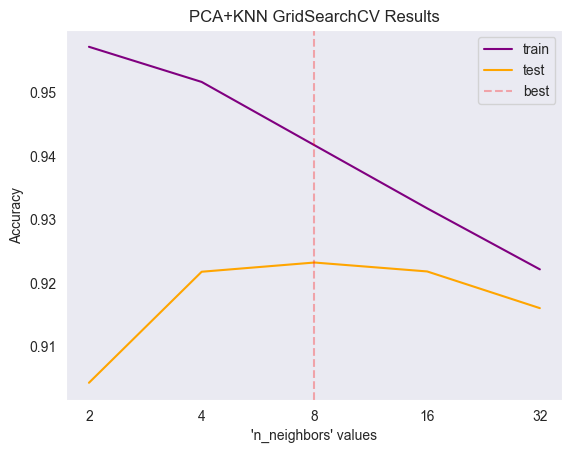

In [21]:
#  to check for overfitting.

fig, ax = plt.subplots()

ax.plot(range(len(knn_clf_params['knn__n_neighbors'])), knn_clf_gs.cv_results_['mean_train_score'],label='train', color='purple')
ax.plot(range(len(knn_clf_params['knn__n_neighbors'])), knn_clf_gs.cv_results_['mean_test_score'], label='test', color='orange')
ax.set_xticks(ticks=range(len(knn_clf_params['knn__n_neighbors'])), labels=knn_clf_params['knn__n_neighbors'])

ii = knn_clf_params['knn__n_neighbors'].index(knn_clf_gs.best_params_['knn__n_neighbors'])

plt.axvline(x=ii, linestyle='--', color='red', label='best', alpha=0.3)
plt.legend()
plt.xlabel("'n_neighbors' values")
plt.ylabel('Accuracy')
plt.title("PCA+KNN GridSearchCV Results")
plt.show()

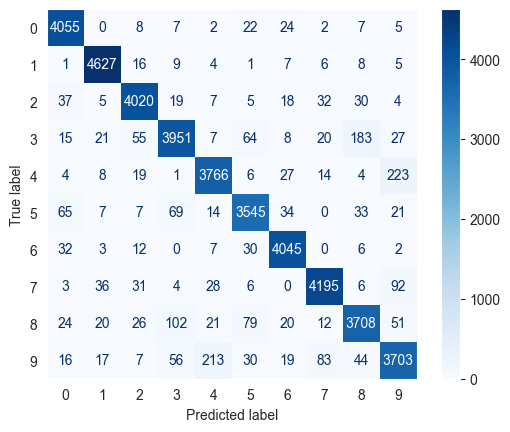

In [22]:
# the Confusion Matrix
best_cv_clf = knn_clf_gs.best_estimator_
y_pred = best_cv_clf.predict(X=X_train)
conf_matrix = confusion_matrix(y_true=y_train, y_pred=y_pred)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_disp.plot(cmap='Blues')

In [23]:
# Classification Report
clf_report = classification_report(y_true=y_train, y_pred=y_pred, labels=range(10))
print(clf_report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4132
           1       0.98      0.99      0.98      4684
           2       0.96      0.96      0.96      4177
           3       0.94      0.91      0.92      4351
           4       0.93      0.92      0.93      4072
           5       0.94      0.93      0.93      3795
           6       0.96      0.98      0.97      4137
           7       0.96      0.95      0.96      4401
           8       0.92      0.91      0.92      4063
           9       0.90      0.88      0.89      4188

    accuracy                           0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000



# Result:
---
- On running the classification of the MNSIT Database using PCA and KNN, gets `Accuracy of 94%`
# Predictions 

In [24]:
#Accuracy = 94%
X_test = test_df.values
print('X_test shape:', X_test.shape)

X_test shape: (28000, 784)


In [25]:
# Initalize the final KNNeigboursClassifier
best_n_neighbors = knn_clf_gs.best_params_['knn__n_neighbors']
final_knn_clf = Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=10)), ('knn', KNeighborsClassifier(n_neighbors=best_n_neighbors))])
final_knn_clf.fit(X=X_train, y=y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=10)),
                ('knn', KNeighborsClassifier(n_neighbors=8))])

In [26]:
predictions = final_knn_clf.predict(X=X_test)
print('Test predictions = ', predictions)

Test predictions =  [2 0 9 ... 3 9 2]
